In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.python.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.python.util import nest

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.callbacks import TQDMProgressBar

%run ../gridsearch/xception.ipynb

In [3]:
# A separate dataset for training a denoising network with fixed PSF and fixed noise
# Starting random seed for data generation 2314662
basedir = Path("../../")
dataset = basedir / "./data/data_v1a.npz"
modelpath = "edsr.tf"

with np.load(dataset) as data:
    print("Available variables:", data.files)
    noisy = data["img"]
    noiseless = data["img_nonoise"]

Available variables: ['img', 'img_nonoise', 'label', 'psf_r', 'snr', 'sigma']


In [4]:
subset = 100_000
X = noisy[:subset, ..., np.newaxis]
Y = noiseless[:subset, ..., np.newaxis]

input_shape = X.shape[1:]

In [5]:
def edsr(input_shape, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    x_in = Input(shape=input_shape)
    x = preprocessing.Normalization()(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = Conv2D(1, 3, padding='same')(x)

    return Model(x_in, x, name="edsr")


def res_block(x_in, filters, scaling):
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x

In [6]:
model = edsr(input_shape, num_filters=256, num_res_blocks=16, res_block_scaling=0.1)
model.compile(optimizer=Adam(0.0001), loss="mae")

adapt_model(model, X)
model.summary()

Model: "edsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 64, 64, 1)    3           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 256)  2560        normalization[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 256)  590080      conv2d[0][0]                     
_______________________________________________________________________________________________

In [7]:
# Setup callbacks
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
tqdm_callback = TQDMProgressBar()
checkpoint = ModelCheckpoint(modelpath, save_best_only=True)

model.fit(
    X,
    Y,
    batch_size=32,
    epochs=1000,
    validation_split=0.1,
    verbose=0,
    callbacks=[early_stopping, tqdm_callback, checkpoint],
)
model.save(modelpath)

Epoch 1/1000



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 2/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 3/1000



Epoch 4/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 5/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 6/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 7/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 8/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 9/1000



Epoch 10/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 11/1000



Epoch 12/1000



Epoch 13/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 14/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 15/1000



Epoch 16/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 17/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 18/1000



Epoch 19/1000



Epoch 20/1000



Epoch 21/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 22/1000



Epoch 23/1000



Epoch 24/1000



Epoch 25/1000



Epoch 26/1000



Epoch 27/1000



Epoch 28/1000



Epoch 29/1000



Epoch 30/1000



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 31/1000



Epoch 32/1000



Epoch 33/1000



Epoch 34/1000



Epoch 35/1000



Epoch 36/1000



Epoch 37/1000



Epoch 38/1000



Epoch 39/1000



Epoch 40/1000



Epoch 41/1000



Epoch 42/1000



Epoch 43/1000



Epoch 44/1000



Epoch 45/1000



Epoch 46/1000



Epoch 47/1000



Epoch 48/1000



Epoch 49/1000



Epoch 50/1000




INFO:tensorflow:Assets written to: edsr.tf/assets


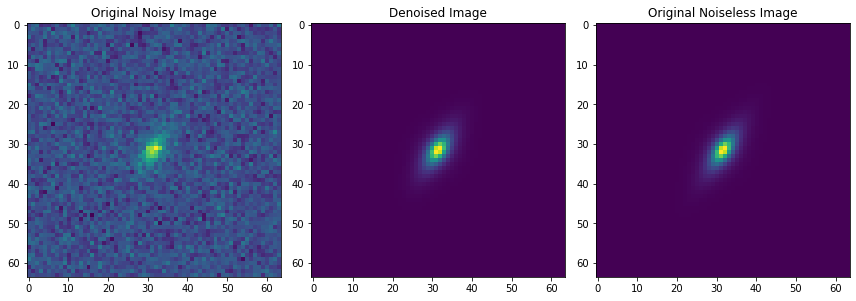

In [8]:
# Plot the results
image_idx = -8
pred = model.predict(X[np.newaxis, image_idx])[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
ax[0].imshow(X[image_idx].reshape(64, 64))
ax[0].set_title("Original Noisy Image")
ax[1].imshow(pred.reshape(64, 64))
ax[1].set_title("Denoised Image")
ax[2].imshow(Y[image_idx].reshape(64, 64))
ax[2].set_title("Original Noiseless Image");

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


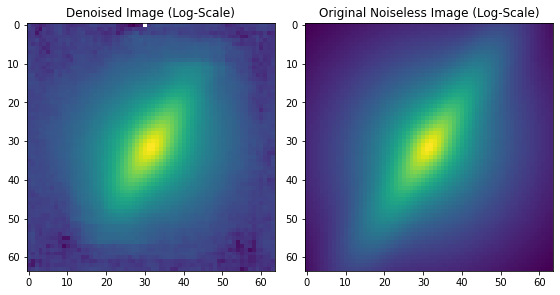

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
ax[0].imshow(np.log(pred).reshape(64, 64))
ax[0].set_title("Denoised Image (Log-Scale)")
ax[1].imshow(np.log(Y[image_idx]).reshape(64, 64))
ax[1].set_title("Original Noiseless Image (Log-Scale)");